In [19]:
#导入必要的包
import numpy as np
import pandas as pd
import yfinance as yf
import sklearn.decomposition as dp
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [20]:
#获取深证B指的样本股
stock_name = pd.read_excel("./SZB.xlsx")

In [21]:
#前五个样本股
stock_name.head()

,证券代码,证券简称,总股本,流通股本,行业,计算标志
0,200011,深物业,"67,605,243","67,605,243",K70 房地产业,1
1,200012,南玻,"1,109,369,060","1,109,369,060",C30 非金属矿物制品业,1
2,200016,深康佳,"811,351,608","811,351,608",C39 计算机、通信和其他电子设备,1
3,200017,深中华,"248,362,982","248,362,982",C37 铁路、船舶、航空航天和其他,1
4,200019,深粮,"51,749,280","51,749,280",F51 批发业,1


In [4]:
#构建数据集
stock_price = pd.DataFrame()
index = [str(x) + ".SZ" for x in list(stock_name["证券代码"])]
name = list(stock_name["证券简称"])

In [5]:
#从雅虎财经爬取样本股股价数据
for i in range(len(index)):
    x = yf.download(index[i], '2020-01-01', '2022-12-31')['Close']
    stock_price[name[i]] = x.dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [6]:
#获取深证B指的指数数据
x = yf.download('399108.SZ','2020-01-01', '2022-12-31')['Close']
stock_price['深证B指'] = x.dropna()

[*********************100%***********************]  1 of 1 completed


In [7]:
#对数据集中缺失值进行填充
stock_price = stock_price.fillna(method="ffill")

In [8]:
X = stock_price.loc[:,name]
Y = stock_price.loc[:,'深证B指']

In [9]:
#训练集和测试集进行划分
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

In [10]:
#构建模型选择函数
def get_selected_variable(model, name, n_features, X, Y):
    sfs_forward = SequentialFeatureSelector(
        model, n_features_to_select=n_features, direction="forward"
        ).fit(X,Y)
    selected_variables = []
    for i in range(len(sfs_forward.support_)):
        if sfs_forward.support_[i] == True:
            selected_variables.append(name[i])
    return selected_variables

In [11]:
#通过改变所选特征数目，比较模型在测试集上的准确率
clf = LinearRegression()
accuracy = []
for i in range(15):
    selected_variables = get_selected_variable(clf, name, i+1, X_train, Y_train)
    clf.fit(X_train.loc[:,selected_variables], Y_train)
    accuracy.append(clf.score(X_test.loc[:,selected_variables], Y_test))
    print("Number of Variables: {0}, Accuarcy on test set: {1}".format(len(selected_variables),accuracy[-1]))

Number of Variables: 1, Accuarcy on test set: 0.7978174119963489
Number of Variables: 2, Accuarcy on test set: 0.9181745701777275
Number of Variables: 3, Accuarcy on test set: 0.953563173976802
Number of Variables: 4, Accuarcy on test set: 0.9688312570150637
Number of Variables: 5, Accuarcy on test set: 0.9831070675910232
Number of Variables: 6, Accuarcy on test set: 0.9886981642138831
Number of Variables: 7, Accuarcy on test set: 0.9928656940890659
Number of Variables: 8, Accuarcy on test set: 0.9941009319677854
Number of Variables: 9, Accuarcy on test set: 0.9957245463065014
Number of Variables: 10, Accuarcy on test set: 0.9964645384061269
Number of Variables: 11, Accuarcy on test set: 0.9969970796364694
Number of Variables: 12, Accuarcy on test set: 0.9973222216135105
Number of Variables: 13, Accuarcy on test set: 0.9978860041487257
Number of Variables: 14, Accuarcy on test set: 0.9978675855434904
Number of Variables: 15, Accuarcy on test set: 0.9981277308957316


Text(0, 0.5, 'Accuracy on Test Set')

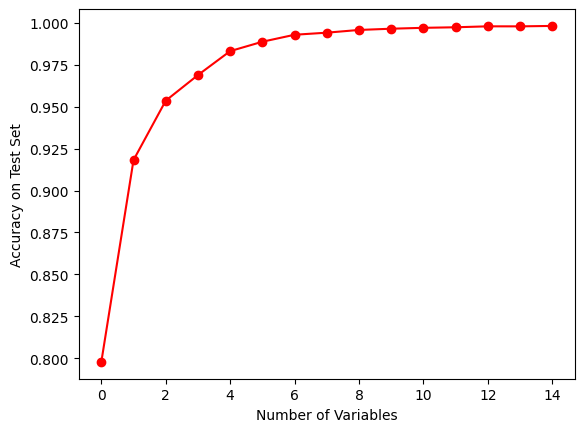

In [12]:
#做出模型在测试集上准确率随特征数目的变化曲线
plt.plot(accuracy,'ro-')
plt.xlabel("Number of Variables")
plt.ylabel("Accuracy on Test Set")

In [13]:
#选取5个特征
selected_variables = get_selected_variable(clf, name, 5, X_train, Y_train)

In [14]:
selected_variables

['深华发', '江铃', '古井贡', '长安', '杭汽轮']

In [15]:
#进行模型拟合
clf.fit(X_train.loc[:,selected_variables], Y_train)

LinearRegression()

In [16]:
#获取模型在测试集上的准确率
clf.score(X_test.loc[:,selected_variables], Y_test)

0.9831070675910232

In [17]:
pred = clf.predict(X_test.loc[:,selected_variables])

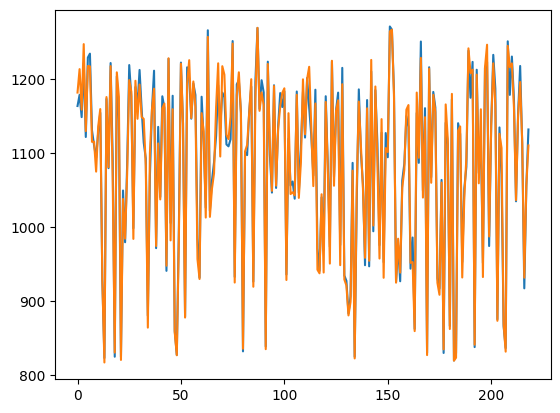

In [18]:
#做出模型在测试集上的预测值与真值
plt.plot(pred)
plt.plot(Y_test.values)